# Which seasonal windows and locations optimize safety—combining sunshine hours, wind-gust flags, and frost/heat indicators?

In [10]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 3.6 MB/s eta 0:00:00


+----------+------+----------+---------------------+------------------+------------------+------------------+------------------+------------------+
|station_id|season|bundesland|elevation_zone       |avg_sunshine      |wind_gust_freq    |frost_freq        |heat_freq         |safety_score      |
+----------+------+----------+---------------------+------------------+------------------+------------------+------------------+------------------+
|15410     |Spring|Salzburg  |2000+ m (High Alpine)|461.3076923076923 |30.5982905982906  |30.094017094017094|1.829059829059829 |398.7863247863248 |
|213       |Spring|Salzburg  |2000+ m (High Alpine)|440.77710843373495|30.596385542168676|30.00602409638554 |2.0180722891566263|378.1566265060241 |
|15411     |Spring|Salzburg  |2000+ m (High Alpine)|394.0877192982456 |30.596491228070175|29.869158878504674|2.4693877551020407|331.1526814365687 |
|15410     |Summer|Salzburg  |2000+ m (High Alpine)|336.05982905982904|27.367521367521366|16.034188034188034|1.1

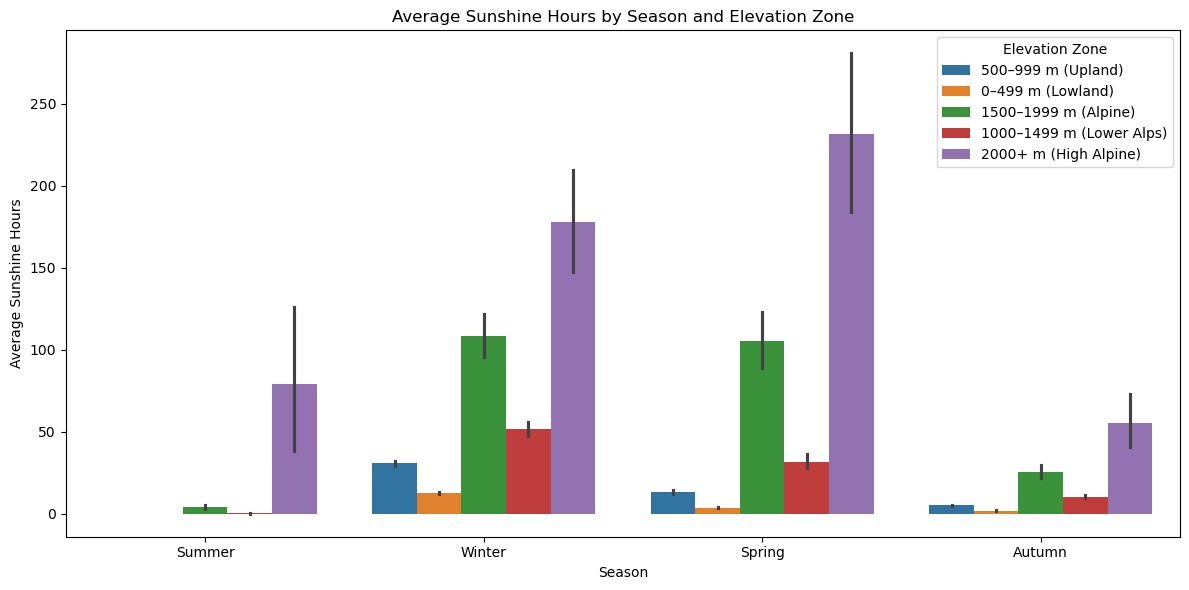

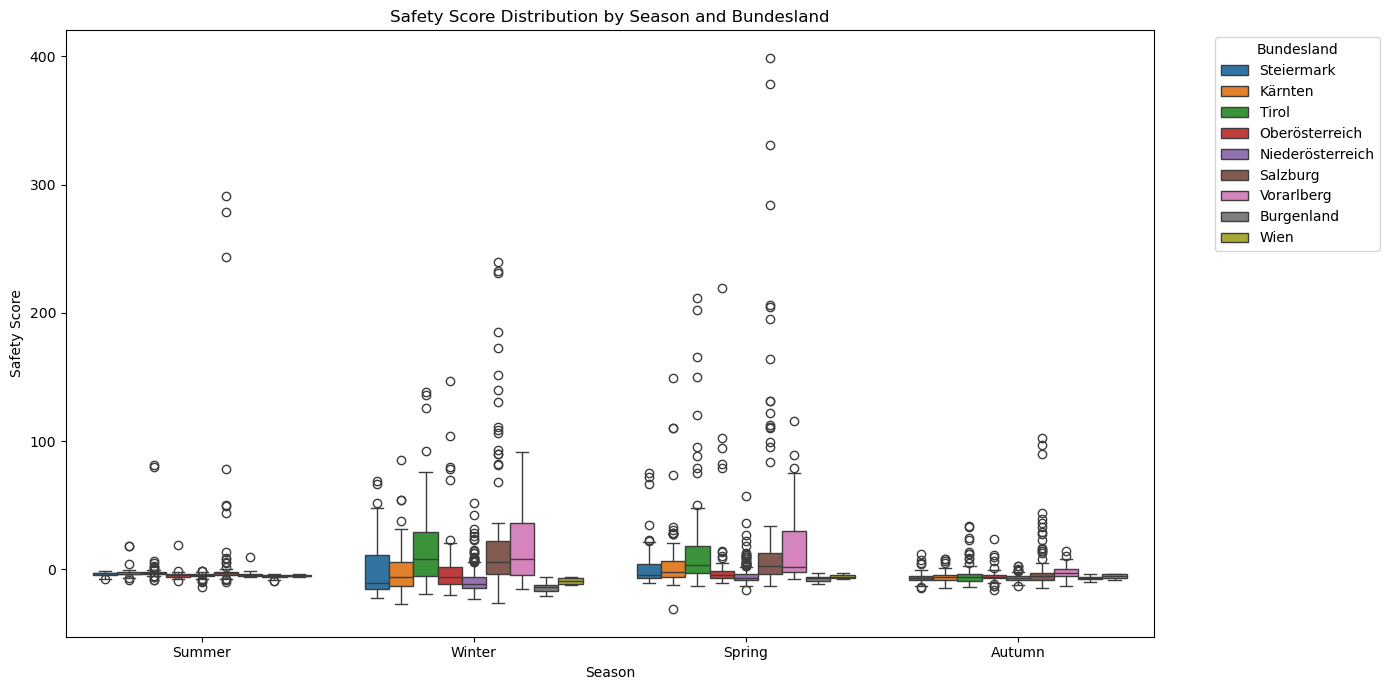

Map saved to /home/jovyan/work/safety_map.html


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, avg, col, when, udf
from pyspark.sql.types import StringType
import folium
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

# Initialize Spark session
spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').getOrCreate()

# Paths
csv_path = "/home/jovyan/work/climate_all_stations.csv"
meta_path = "/home/jovyan/work/stations_metadata.csv"

# Load climate CSV with inferred schema
climate_df = spark.read.option("header", True).option("inferSchema", True).csv(csv_path)

# Load metadata and rename columns
stations_meta = spark.read.option("header", True).option("inferSchema", True).csv(meta_path)
stations_meta = stations_meta.withColumnRenamed("id", "station_id") \
                             .withColumnRenamed("Höhe [m]", "altitude") \
                             .withColumnRenamed("Breite [°N]", "latitude") \
                             .withColumnRenamed("Länge [°E]", "longitude") \
                             .withColumnRenamed("Bundesland", "bundesland")

# Join climate data with metadata on station_id
df_joined = climate_df.join(stations_meta, on="station_id")

# Define season UDF
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

season_udf = udf(get_season, StringType())

# Add month and season columns
df_season = df_joined.withColumn("month", month("date"))
df_season = df_season.withColumn("season", season_udf("month"))

# Define elevation zones
df_season = df_season.withColumn(
    "elevation_zone",
    when(col("altitude") < 500, "0–499 m (Lowland)")
    .when(col("altitude") < 1000, "500–999 m (Upland)")
    .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
    .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
    .otherwise("2000+ m (High Alpine)")
)

# Map your column names:
# Sunshine: use "sh_manu_max" (manual sunshine max)
# Wind gusts: use "tage_sh_manu_100" (days with strong wind gusts)
# Frost days: "tage_frost"
# Heat days: "tage_heit"

# Aggregate metrics per station, season, bundesland, elevation zone
agg_df = df_season.groupBy("station_id", "season", "bundesland", "elevation_zone") \
    .agg(
        avg("sh_manu_max").alias("avg_sunshine"),
        avg("tage_sh_manu_100").alias("wind_gust_freq"),
        avg("tage_frost").alias("frost_freq"),
        avg("tage_heit").alias("heat_freq"),
    )

# Safety score = sunshine - (wind gust + frost + heat)
agg_df = agg_df.withColumn(
    "safety_score",
    col("avg_sunshine") - col("wind_gust_freq") - col("frost_freq") - col("heat_freq")
)

# Show top safety scores
agg_df.orderBy(col("safety_score").desc()).show(10, truncate=False)

# Convert to pandas for plotting/mapping
agg_pd = agg_df.toPandas()

# Merge coordinates for mapping
stations_meta_pd = stations_meta.select("station_id", "latitude", "longitude").toPandas()
agg_pd = agg_pd.merge(stations_meta_pd, on="station_id", how="left")

# Plot average sunshine by season and elevation zone
plt.figure(figsize=(12,6))
sns.barplot(data=agg_pd, x="season", y="avg_sunshine", hue="elevation_zone")
plt.title("Average Sunshine Hours by Season and Elevation Zone")
plt.ylabel("Average Sunshine Hours")
plt.xlabel("Season")
plt.legend(title="Elevation Zone")
plt.tight_layout()
plt.show()

# Plot safety score by Bundesland and season
plt.figure(figsize=(14,7))
sns.boxplot(data=agg_pd, x="season", y="safety_score", hue="bundesland")
plt.title("Safety Score Distribution by Season and Bundesland")
plt.ylabel("Safety Score")
plt.xlabel("Season")
plt.legend(title="Bundesland", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# Folium map: stations colored by mean safety score
agg_mean_safety = agg_pd.groupby("station_id")[["safety_score"]].mean().reset_index()
agg_map_data = agg_mean_safety.merge(stations_meta_pd, on="station_id")

m = folium.Map(location=[47.5, 13.5], zoom_start=7)
for _, row in agg_map_data.iterrows():
    color = 'green' if row['safety_score'] > 0 else 'red'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"Station: {row['station_id']}\nAvg Safety Score: {row['safety_score']:.2f}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(m)

map_path = "/home/jovyan/work/safety_map.html"
m.save(map_path)
display(m)
print(f"Map saved to {map_path}")
